### Pip Install Operations


In [ ]:
! pip install spektral
! pip install ogb
! pip install torch_geometric
! pip install pdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 11.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=767bad851a73b36cae3063a5036678fedc6ed40ef11c8ece9f2c45cff23936c2
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 29.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.tom

## Setup


In [ ]:
import torch
from torch_geometric.data import Data
import random
import numpy as np
import math
import time

from spektral.datasets.ogb import OGB
from spektral.transforms import AdjToSpTensor, GCNFilter
from ogb.nodeproppred import Evaluator, NodePropPredDataset

from torch_geometric.nn import GCNConv
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F

from torch_geometric.utils import negative_sampling

from itertools import product, combinations

from sklearn.metrics import recall_score
import itertools

import pdb

import pickle
import matplotlib.pyplot as plt

In [ ]:


train_edge_percentage = 0.5
V_percentage = 0.95


import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"



## Dataset Related


### Applying dataset splits



## TUNEUP

### Overall fine-tune approach

In [ ]:
def fine_tune(model, V, data, train_edges, val_edges, optimizer, drop_percent=0.2, patience=10, epochs = 1000, test_active = True):

  # Define some initial best validation loss as infinity
  best_val_loss = float('inf')
  epochs_no_improve = 0

  # Training loop
  data, train_edges, val_edges = data.to(device), train_edges.to(device), val_edges.to(device)
  for epoch in range(epochs):  # 1000 epochs
      print("epoch ", epoch)

      model.train()
      optimizer.zero_grad()

      # Drop edges from the graph
      data_kept, _ = random_edge_sampler(data, drop_percent)
      kept_edges = data_kept.edge_index.to(device)  # Fetching the edge index from the kept data

      z_train = model(data, kept_edges)  # embeddings for training edges


      pos_edge_index = train_edges  # positive examples
      neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=z_train.size(0))  # negative examples

      pos_logit = model.decode(z_train, pos_edge_index)
      neg_logit = model.decode(z_train, neg_edge_index)

      loss = bpr_loss(pos_logit, neg_logit)

      loss.backward()
      optimizer.step()

      print("train loss: ", loss.item())



      # Validation:
      if (epoch +1) % 5 == 0:
        # validation function calls model.eval(), calculating both val loss & recall@50
        val_loss = validation(model, V, val_edges, z_train)
        # append the val loss to the val_losses
        val_losses.append(val_loss)
        print(f'Validation Loss: {val_loss}')
        if test_active:
          res = test(model, V, val_edges,z_train, 50)
          print("recall@50: ", res)

        """
        # Check if early stopping conditions are met
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch+1} epochs.')
                break
        """


      # save the model @ each 200 epochs
      if (epoch +1) % 100 == 0:
        save_all(model, train_losses, val_losses, epoch +1)

  # save @ exit
  save_all(model, train_losses, val_losses, epochs)


### TUNEUP w/o syn-tails

normal train + normal train again

In [ ]:
##########################
##### TuneUp w/o syn-tails
##########################

def tune_up_wo_syn_tails(model,  V, data, train_edges, val_edges, optimizer, num_epochs_train, test_active_train, num_epochs_finetune, test_active_finetune):
  # train the model
  train(model, V, data, train_edges, val_edges, optimizer=optimizer, epochs=num_epochs_train, test_active=test_active_train)

  # fine tune the model with  the same data
  train(model, V, data, train_edges, val_edges, optimizer=optimizer, epochs=num_epochs_finetune, test_active=test_active_finetune)

### TUNEUP w/o curriculum

interleave the 1st and 2nd stage preds.

```
for each epoch:
  // 1st stage
  Y = F(G)
  loss  = loss(Y, Y_true)
  loss.backprop()

  // 2nd stage
  G' <-- DropEdge(G)
  Y = F(G')
  loss  = loss(Y, Y_true)
  loss.backprop()
  ```

In [ ]:
def tune_up_wo_curriculum(model, V, data, train_edges, val_edges, optimizer, drop_percent=0.2, patience=10, epochs = 1000, test_active = True):

  # Define some initial best validation loss as infinity
  best_val_loss = float('inf')
  epochs_no_improve = 0

  # Training loop
  data, train_edges, val_edges = data.to(device), train_edges.to(device), val_edges.to(device)
  for epoch in range(epochs):  # 1000 epochs
      print("epoch ", epoch)

      model.train()
      optimizer.zero_grad()

      # Stage 1: Train on the full graph
      z_train_full = model(data, train_edges)  # embeddings for training edges on the full graph
      pos_edge_index_full = train_edges  # positive examples on the full graph
      neg_edge_index_full = negative_sampling(edge_index=pos_edge_index_full, num_nodes=z_train_full.size(0))  # negative examples
      pos_logit_full = model.decode(z_train_full, pos_edge_index_full)
      neg_logit_full = model.decode(z_train_full, neg_edge_index_full)
      loss_full = bpr_loss(pos_logit_full, neg_logit_full) # calc loss
      loss_full.backward() # backward pass
      optimizer.step()


      # Stage 2: Drop edges and train the graph with dropped edges
      data_kept, _ = random_edge_sampler(data, drop_percent)
      kept_edges = data_kept.edge_index.to(device)  # Fetching the edge index from the kept data

      z_train_kept = model(data, kept_edges)  # embeddings for training edges on the graph with dropped edges
      pos_edge_index_kept = train_edges  # positive examples on the graph with dropped edges
      neg_edge_index_kept = negative_sampling(edge_index=pos_edge_index_kept, num_nodes=z_train_full.size(0))  # negative examples
      pos_logit_kept = model.decode(z_train_kept, pos_edge_index_kept)
      neg_logit_kept = model.decode(z_train_kept, neg_edge_index_kept)
      loss_kept = bpr_loss(pos_logit_kept, neg_logit_kept) # calc loss
      loss_kept.backward() # backward pass
      optimizer.step()

      print("train loss: ", loss_full.item() + loss_kept.item())



### TUNEUP (OURS)

```
// 1st stage
for each epoch:
  model.train()
  Y = F(G)
  loss  = loss(Y, Y_true)
  loss.backprop()

// 2nd stage
for each epoch:
  model.train()
  G' <-- DropEdge(G)
  Y = F(G')
  loss  = loss(Y, Y_true)
  loss.backprop()

  ```

In [ ]:
def tune_up_ours(model,  V, data, train_edges, val_edges, optimizer, num_epochs_train, test_active_train, num_epochs_finetune, test_active_finetune):
  # straightforward train
  train(model, V, data, train_edges, val_edges, optimizer=optimizer, epochs=num_epochs_train, test_active=test_active_train)

  # two-stage curriculum
  fine_tune(model, V, data, train_edges, val_edges, optimizer=optimizer, drop_percent=0.2, patience=10, epochs = num_epochs_finetune, test_active = test_active_finetune)

In [ ]:
# overall method for tuning up
# takes mode = {TUNEUP, wo_syn_tails, wo_curriculum} 
def tune_up(model,  V, data, train_edges, val_edges, optimizer, num_epochs_train, test_active_train, num_epochs_finetune, test_active_finetune, mode):
    if mode == "TUNEUP":
        tune_up_ours(model,  V, data, train_edges, val_edges, optimizer, num_epochs_train, test_active_train, num_epochs_finetune, test_active_finetune)
    if mode == "wo_syn_tails":
        tune_up_wo_syn_tails(model,  V, data, train_edges, val_edges, optimizer, num_epochs_train, test_active_train, num_epochs_finetune, test_active_finetune)

## Utils

### Model and loss saving

### Recall calculation


### Find intersection, remove it


### TuneUP: Synthesizing tail nodes

In [ ]:
from torch_geometric.utils import degree




"""
## USAGE:

# percent: rate of edges to keep
data_kept, data_dropped = random_edge_sampler(data, percent)

## INPUT:
Data(x=[169343, 128], edge_index=[2, 1335586], y=[169343, 1])

## RETURNS:
(Data(edge_index=[2, 468243]), Data(edge_index=[2, 962188]))

"""

'\n## USAGE:\n\n# percent: rate of edges to keep\ndata_kept, data_dropped = random_edge_sampler(data, percent)\n\n## INPUT:\nData(x=[169343, 128], edge_index=[2, 1335586], y=[169343, 1])\n\n## RETURNS:\n(Data(edge_index=[2, 468243]), Data(edge_index=[2, 962188]))\n\n'

# Execution



### To Device

In [ ]:
model = GCN(128)

model = model.to(device)
data = data.to(device)
E_train = E_train.to(device)
E_val = E_val.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)  # L2 regularization

train(model, V, data, train_edges=E_train, val_edges=valid_edges_in_V, optimizer=optimizer, test_active = False)


epoch  0
train loss:  532673.5
epoch  1
train loss:  488857.59375
epoch  2
train loss:  452074.8125
epoch  3
train loss:  422494.25
epoch  4
train loss:  400266.53125
Validation Loss: 354749.3125
epoch  5
train loss:  382573.1875
epoch  6
train loss:  368171.3125
epoch  7
train loss:  355774.5
epoch  8
train loss:  344933.21875
epoch  9
train loss:  335604.9375
Validation Loss: 303909.28125
epoch  10
train loss:  326827.375
epoch  11
train loss:  319304.71875
epoch  12
train loss:  311893.9375
epoch  13
train loss:  305553.375
epoch  14
train loss:  299533.5
Validation Loss: 274728.59375
epoch  15
train loss:  293626.34375
epoch  16
train loss:  288425.09375
epoch  17
train loss:  283334.53125
epoch  18
train loss:  278404.5625
epoch  19
train loss:  273777.84375
Validation Loss: 254521.234375
epoch  20
train loss:  269952.1875
epoch  21
train loss:  265963.84375
epoch  22
train loss:  261648.421875
epoch  23
train loss:  258479.34375
epoch  24
train loss:  254941.8125
Validation Loss:

### Loading the saved model and losses

In [ ]:
#### loading losses
train_losses = []
val_losses = []

with open('/content/gdrive/My Drive/TUNEUP/train_losses_1001.pkl', 'rb') as f:
    train_losses = pickle.load(f)

with open('/content/gdrive/My Drive/TUNEUP/val_losses_1001.pkl', 'rb') as f:
    val_losses = pickle.load(f)

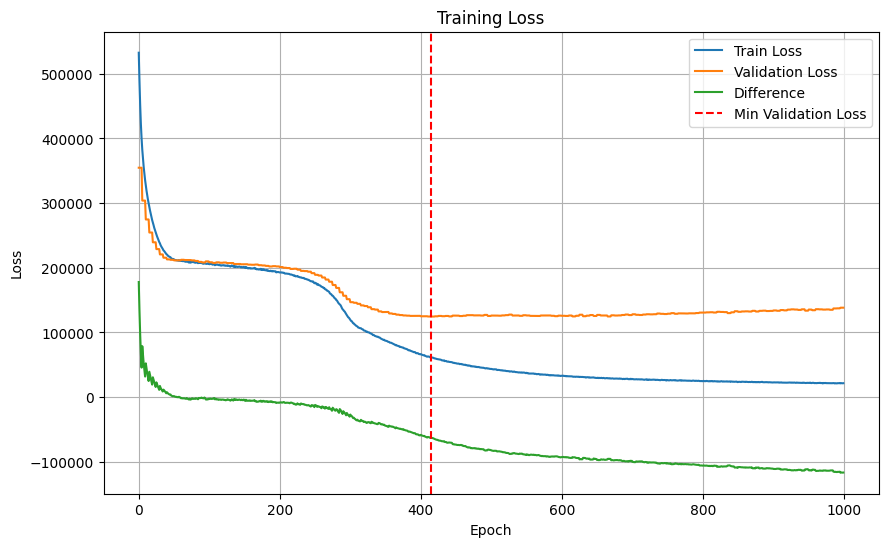

In [ ]:
# Convert the tensor to a list
train_loss = [loss.item() for loss in train_losses]
val_loss = [loss for loss in val_losses]
val_loss_stretched = []
for loss in val_loss:
    val_loss_stretched.extend([loss]*5)  # Change the number accordingly

diff = np.array(train_loss) - np.array(val_loss_stretched)

# Find the epoch with minimum validation loss
min_loss_index = np.argmin(val_loss)

# Now plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss)
plt.plot(val_loss_stretched)
plt.plot(diff)
plt.axvline(x=min_loss_index * 5, color='r', linestyle='--')  # Add vertical line at minimum validation loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend(["Train Loss", "Validation Loss", "Difference", "Min Validation Loss"])
plt.show()




In [ ]:
model = GCN(128)

model_save_path = save_path + "/model_401.pt"

model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [ ]:
fine_tune(model, V, data, train_edges=E_train, val_edges=valid_edges_in_V, optimizer=optimizer, drop_percent=0.2, patience=10, epochs = 10, test_active = True)